# GMM on Original Data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from GMM import GMM
from covariance_types import CovarianceType
import seaborn as sns

load data

In [ ]:
X = pd.read_csv("../data_processed.csv").to_numpy()

initialize the GMM

In [ ]:
gmm = GMM(k=3,covariance_type=CovarianceType.FULL,conv_limit=1e-6,max_iter=100)

Initialize covariance types and number of clusters

In [ ]:
covariance_types = [CovarianceType.FULL, CovarianceType.TIED,
                    CovarianceType.DIAG, CovarianceType.SPHERICAL]
k_vals = range(1, 10)

Initialize AIC and BIC results

In [ ]:
aic_results = {cov: [] for cov in covariance_types}
bic_results = {cov: [] for cov in covariance_types}

## Training

Get AIC and BIC for each covariance type and number of clusters

In [ ]:
results = []
for cov_type in covariance_types:
    for k in k_vals:
        gmm_instance = GMM(k=k, covariance_type=cov_type, conv_limit=1e-4, max_iter=100)
        gmm_instance.fit(X)
        bic_score = gmm_instance.bic(X)
        aic_score = gmm_instance.aic(X)
        results.append({
            "Number of components": k,
            "cov_type": str(cov_type).split('.')[-1],  # convert enum to string
            "BIC": bic_score,
            "AIC": aic_score
        })

df_metrics = pd.DataFrame(results)

Get the best model

In [45]:
best_bic_row = df_metrics.loc[df_metrics['BIC'].idxmin()]
best_k = best_bic_row['Number of components']
best_cov = best_bic_row['cov_type']

best_gmm = GMM(k=best_k, covariance_type=best_cov, conv_limit=1e-4, max_iter=100)
best_gmm.fit(X)

Assign clusters

In [46]:
r = best_gmm.r
labels = np.argmax(r, axis=1)

## Plotting

Plot the best model

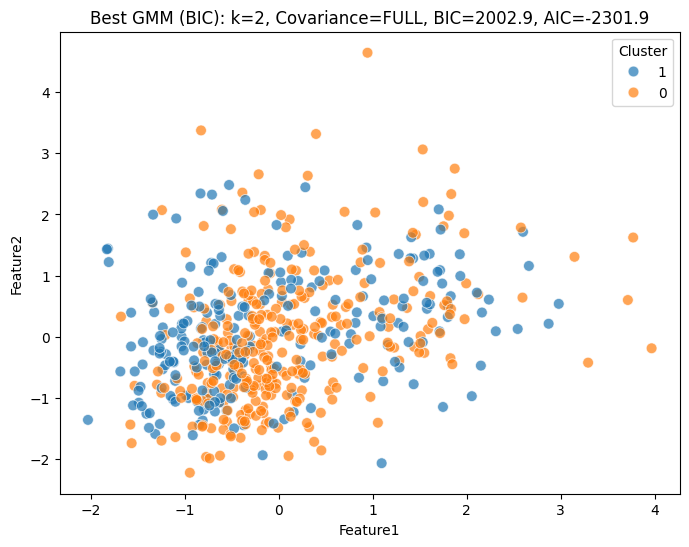

In [ ]:
df = pd.DataFrame({
    'Feature1': X[:,0],
    'Feature2': X[:,1],
    'Cluster': labels.astype(str)
})
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Feature1', y='Feature2', hue='Cluster', palette='tab10', s=60, alpha=0.7)
plt.title(f"Best GMM (BIC): k={best_k}, Covariance={str(best_cov).split('.')[-1]}, BIC={best_bic_row['BIC']:.1f}, AIC={best_bic_row['AIC']:.1f}")
plt.show()

Plot BIC

In [44]:
sns.lineplot(
    data=df_bic,
    x="Number of components",
    y="BIC",
    hue="cov_type",
    marker="o"
)
plt.title("BIC vs Number of Components")
plt.show()

ValueError: Could not interpret value `BIC` for `y`. An entry with this name does not appear in `data`.

Plot AIC

In [38]:
# Line plot for AIC
sns.lineplot(
    data=df_aic,
    x="Number of components",
    y="AIC",
    hue="cov_type",
    marker="o"
)
plt.title("AIC vs Number of Components")
plt.show()

ValueError: Could not interpret value `AIC` for `y`. An entry with this name does not appear in `data`.

Since most of the features are correlated: by minimizing the covariance, the accuracy decreases. Therefore, the optimum scores are found at the full covariance and the worst scores are found at the spherical covariance where all correlation is diminshed.

Since the dataset is binary, according to our knowledge, the optimum number of Gaussians is 2. As the number of Gaussians increases, the more it leads to overfitting 